# STEAP
## Post-Processing Notebook 
### Example: Depression

In this notebook the example depression GWAS will be further analysed.

1.    [Significant cell-types will be identified from the output file](#1)

2.    [These cell-types will be compared to enriched cell-types in other phenotypes to observe any overlap (using upsetplot)](#2)
3.    [Gene-Set Enrichment Analysis (GSEA) will be applied on the genes specific for the enriched cell-types](#3)
4.    [Correlations between other phenotypes will be calculated using beta correlation/cell-type correlation](#4)
5.    [Expression Specificity (ES) gene correlation will be calculated between cell-types to observe any similarity between them](#5)

This notebook can be used for any GWAS phenotype of interest, not just depression.
Just edit the the necessary variables to include your analyzed phenotype.

In [1]:
cellect_out_dir = "out/CELLECT-PGC_UKB_depression" # output dir of CELLECT
gwas_name = 'PGC_UKB_depression' # the id of the GWAS (found in the config.yml file)

First, we need to import the necessary packages and scripts.

In [2]:
# quick/dirty method to allow importing by changing working directory
import os
os.chdir("../")
os.getcwd()

'/home/eerdem/STEAP'

In [3]:
import pandas as pd
import constants # all constants used here can be found and edited in the constants.py file
from scripts import convert_output_to_dataframe
from scripts import gene_set_enrichment_analysis
from scripts import calculate_beta_correlation
from scripts import calculate_es_correlation
from scripts import upsetplot
from scripts import circosplot

## 1.    Find Significant Cell-Types <a id='1'></a>

The pvalue of the output must first be corrected.
By default it uses bonferroni correction, but other methods can also be applied
(see [`statsmodels.stats.multitest.multipletests`](https://www.statsmodels.org/stable/generated/statsmodels.stats.multitest.multipletests.html)
documentation). Just edit the value of `PVAL_CORRECTION` in the constants.py file to any other method of your choice.

In [4]:
print(constants.PVAL_CORRECTION)

bonferroni


To correct the pvalues, it is the easiest to first convert the data to a pandas dataframe.

In [5]:
df = convert_output_to_dataframe.make_df(cellect_out_dir) # converts to df
df = convert_output_to_dataframe.pvalue_correction(df, method=constants.PVAL_CORRECTION) # corrects pval
display(df)

,gwas,specificity_id,annotation,beta,beta_se,pvalue,method,n_methods,pvalue_bonferroni
0,PGC_UKB_depression,Allen_human_LGN,GABAergic.LGN_Inh_CTXN3,0.191887,0.098577,0.025807,H-MAGMA,3,0.309689
1,PGC_UKB_depression,Allen_human_LGN,GABAergic.LGN_Inh_LAMP5,0.297184,0.079788,0.000098,H-MAGMA,3,0.001180
2,PGC_UKB_depression,Allen_human_LGN,GABAergic.LGN_Inh_NTRK1,0.037360,0.097893,0.351370,H-MAGMA,3,1.000000
3,PGC_UKB_depression,Allen_human_LGN,GABAergic.LGN_Inh_TRPC4,0.244696,0.110040,0.013095,H-MAGMA,3,0.157145
4,PGC_UKB_depression,Allen_human_LGN,Glutamatergic.LGN_Exc_BTNL9,0.356141,0.147471,0.007877,H-MAGMA,3,0.094520
...,...,...,...,...,...,...,...,...,...
1630,PGC_UKB_depression,tabula_muris,Tongue.keratinocyte,-0.099988,0.054974,0.965520,MAGMA,3,1.000000
1631,PGC_UKB_depression,tabula_muris,Trachea.blood_cell,-0.018287,0.071724,0.600625,MAGMA,3,1.000000
1632,PGC_UKB_depression,tabula_muris,Trachea.endothelial_cell,-0.095236,0.067358,0.921288,MAGMA,3,1.000000
1633,PGC_UKB_depression,tabula_muris,Trachea.epithelial_cell,-0.190427,0.063896,0.998557,MAGMA,3,1.000000


To identify the enriched cell-types, we can simply filter out all non-significant hits. In the STEAP pipeline we used three different methods (S-LDSC, MAGMA and H-MAGMA) to determine whether a cell-type is enriched or not.
Here, we define a cell-type to be actually enriched if it is significant in at least 2/3 methods.

In [6]:
significant_counts = df[
        (df[f'pvalue_{constants.PVAL_CORRECTION}']<=0.05) # get only significant hits
].value_counts(['gwas','specificity_id','annotation']) # count in how many methods it is significant

# only get enriched cell-types in >2 methods
significant_counts = significant_counts[
    (significant_counts>=len(constants.METHODS)-1)
]
significant_counts.sort_index(level=1)

gwas                specificity_id              annotation                                      
PGC_UKB_depression  Allen_human_LGN             GABAergic.LGN_Inh_LAMP5                             3
                    Allen_human_MTG             GABAergic.Inh_L2-4_PVALB_WFDC2                      2
                    Descartes_Human_Cerebellum  Cerebellum-Purkinje_neurons                         2
                    Descartes_Human_Cerebrum    Cerebrum-Inhibitory_neurons                         3
                                                Cerebrum-Limbic_system_neurons                      3
                                                Cerebrum-SKOR2_NPSR1_positive_cells                 2
                    DroNc_Human_Hippocampus     GABA1                                               3
                                                GABA2                                               3
                                                exPFC1                                 

## 2.    Overlap of Enriched Cell-Types Between Phenotypes <a id='2'></a>

Let's compare which enriched cell-types in our phenotype of interest are also enriched in other gwas (groups) using the upsetplot. 
To do this we need data of the other phenotypes as well. 
Instead of running the pipeline with 500+ different GWAS, we can just load a pre-computed dataframe.

In [7]:
df_all = pd.read_hdf('data/CELLECT_output/data.h5', 'df_all')
display(df_all)

,gwas,specificity_id,annotation,beta,beta_se,pvalue,method,n_methods,pvalue_bonferroni
0,AD_JANSENS2019,Allen_human_LGN,GABAergic.LGN_Inh_CTXN3,-0.174645,0.089013,0.975106,H-MAGMA,3,1.0
1,AD_JANSENS2019,Allen_human_LGN,GABAergic.LGN_Inh_LAMP5,-0.123540,0.071732,0.957472,H-MAGMA,3,1.0
2,AD_JANSENS2019,Allen_human_LGN,GABAergic.LGN_Inh_NTRK1,-0.269440,0.088436,0.998840,H-MAGMA,3,1.0
3,AD_JANSENS2019,Allen_human_LGN,GABAergic.LGN_Inh_TRPC4,-0.246886,0.099982,0.993223,H-MAGMA,3,1.0
4,AD_JANSENS2019,Allen_human_LGN,Glutamatergic.LGN_Exc_BTNL9,-0.421298,0.133637,0.999188,H-MAGMA,3,1.0
...,...,...,...,...,...,...,...,...,...
879625,volume: thalamus,tabula_muris,Tongue.keratinocyte,-0.035636,0.045386,0.783817,MAGMA,3,1.0
879626,volume: thalamus,tabula_muris,Trachea.blood_cell,-0.102483,0.059198,0.958279,MAGMA,3,1.0
879627,volume: thalamus,tabula_muris,Trachea.endothelial_cell,-0.114722,0.055573,0.980498,MAGMA,3,1.0
879628,volume: thalamus,tabula_muris,Trachea.epithelial_cell,-0.102770,0.052743,0.974312,MAGMA,3,1.0


This data contains 538 unique GWAS phenotypes.
We can group most of these GWASes in three main groups.
1.    Structural MRI Measurements
2.    White Matter DTI Tracts
3.    Resting State fMRI Network

The `GWAS_GROUP_DICT` variable contains information about these groups:

In [8]:
display(constants.GWAS_GROUP_DICT)
# GWAS group name : [(regex) keywords used to match to gwas]

{'Structural MRI': ['volume', 'thickness', 'area'],
 'DTI Tracts': ['DTI'],
 'rs-fMRI Network': ['Net']}

This dictionary contains the GWAS group names as keys and keywords as values.
These keywords can be used to search for the GWAS in the dataframe (using regex).
For instance `volume` is a keywords used to include `volume: thalamus` phenotype in the `Structural MRI` group.

To analyze the phenotype of interest let's include it to the dictionary as well. This can be done by editing the constants.py file directly or:

In [9]:
gwas_group_dict = constants.GWAS_GROUP_DICT.copy()
gwas_group_dict['Depression'] = ['PGC_UKB_depression']
display(gwas_group_dict)

{'Structural MRI': ['volume', 'thickness', 'area'],
 'DTI Tracts': ['DTI'],
 'rs-fMRI Network': ['Net'],
 'Depression': ['PGC_UKB_depression']}

Now we can visualize the overal of cell-types between phenotypes using the upsetplot.

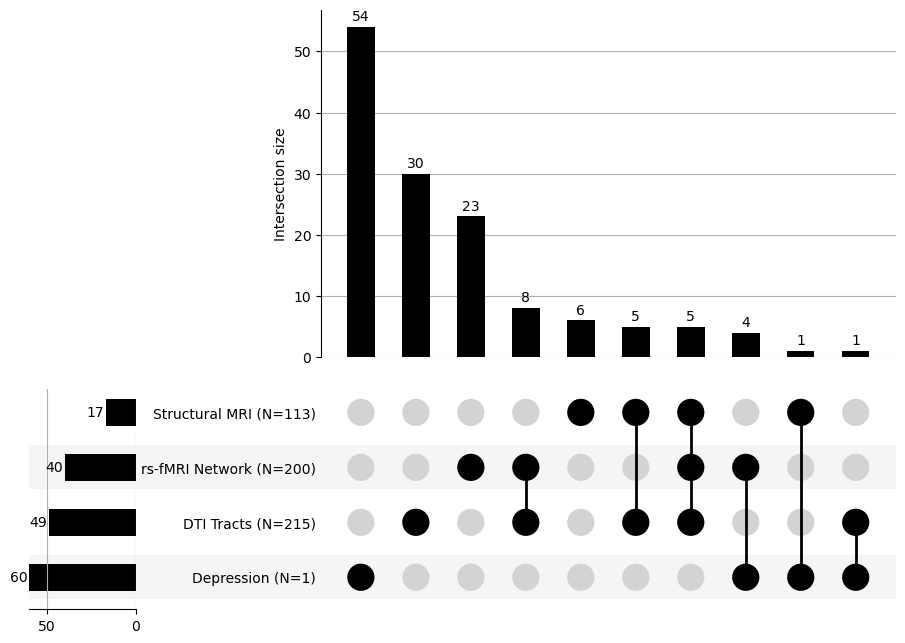

In [10]:
upsetplot.plot_upset(pd.concat([df_all,df]), # concat the preloaded data with the depression df
                     gwas_group_dict,
                     sign_threshold=len(constants.METHODS)-1, # only use cell-types significant in >2 methods
                     element_size=56,
                     save=False)

To investigate which cell-types are actually overlapping, we can save it as an excel file or directly investigate the dataframe.

In [11]:
shared_celltypes_df = upsetplot.get_shared_celltypes(pd.concat([df_all,df]),
                                                     gwas_group_dict,
                                                     sign_threshold=len(constants.METHODS)-1,
                                                     save_to_excel=False)
display(shared_celltypes_df)

,specificity_id,annotation,group,gwas
21,Descartes_Human_Cerebrum,Cerebrum-Excitatory_neurons,"rs-fMRI Network, DTI Tracts, Structural MRI","surface area: Occipital.lateraloccipital, volu..."
37,DroNc_Human_Hippocampus,exCA3,"rs-fMRI Network, DTI Tracts, Structural MRI",cortical thickness (adjusted): Occipital.peric...
45,GSE67835_Human_Cortex,endothelial,"rs-fMRI Network, DTI Tracts, Structural MRI","volume: Temporal.bankssts, DTI RD: SS, DTI MD:..."
46,GSE67835_Human_Cortex,fetal_quiescent,"rs-fMRI Network, DTI Tracts, Structural MRI","DTI PC5: EC, DTI MO: SCC, Net_Edge_ICA6, volum..."
49,GSE67835_Human_Cortex,oligodendrocytes,"rs-fMRI Network, DTI Tracts, Structural MRI","volume: Cingulate.rostralanteriorcingulate, DT..."
...,...,...,...,...
90,mousebrain,SCINH5,rs-fMRI Network,Net100_Pair32_38
116,tabula_muris,Brain_Non-Myeloid.brain_pericyte,rs-fMRI Network,"Net25_Node10, Net25_Node8, Net100_Node27, Net1..."
122,tabula_muris,Heart.myofibroblast_cell,rs-fMRI Network,"Net25_Node10, Net100_Node32, Net25_Node9, Net2..."
123,tabula_muris,Heart.smooth_muscle_cell,rs-fMRI Network,"Net25_Node18, Net100_Node23, Net100_Node17, Ne..."


And to see which cell-types are overlapping with the, in this case, depression group:

In [12]:
shared_celltypes_df[
    shared_celltypes_df['group'].str.contains('Depression')
]

,specificity_id,annotation,group,gwas
51,PsychENCODE_DER-22,Ex3e,"DTI Tracts, Depression","PGC_UKB_depression, DTI FA: CGC, DTI PC1: CGC"
40,DroNc_Human_Hippocampus,exPFC2,"Structural MRI, Depression","PGC_UKB_depression, volume: Parietal.superiorp..."
0,Allen_human_LGN,GABAergic.LGN_Inh_LAMP5,"rs-fMRI Network, Depression","Net100_Pair28_48, PGC_UKB_depression"
22,Descartes_Human_Cerebrum,Cerebrum-Inhibitory_neurons,"rs-fMRI Network, Depression","Net100_Pair20_32, PGC_UKB_depression, Net25_Pa..."
39,DroNc_Human_Hippocampus,exPFC1,"rs-fMRI Network, Depression","PGC_UKB_depression, Net100_Pair8_32"
64,mousebrain,DEGLU4,"rs-fMRI Network, Depression","PGC_UKB_depression, Net100_Pair25_46"
6,Allen_human_MTG,GABAergic.Inh_L2-4_PVALB_WFDC2,Depression,PGC_UKB_depression
17,Descartes_Human_Cerebellum,Cerebellum-Purkinje_neurons,Depression,PGC_UKB_depression
23,Descartes_Human_Cerebrum,Cerebrum-Limbic_system_neurons,Depression,PGC_UKB_depression
25,Descartes_Human_Cerebrum,Cerebrum-SKOR2_NPSR1_positive_cells,Depression,PGC_UKB_depression


## 3.    Gene-Set Enrichment Analysis <a id='3'></a>

We can get additional information about the enriched cell-types using GSEA.
GSEA uses a gene-list as input. 
Here, we select the top 1% of genes with the highest ES value calculated using CELLEX in enriched cell-types.
This percentage can be edited in the constant.py file, but it is recommended to not do this. 
[A range of 15 to 500 genes is recommended by the original GSEA developers](https://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideFrame.html). 
During testing, the top 1% revealed to always have a number of genes in this range.
If during the analysis a gene-list contains a number of genes outisde this range a warning will be printed.

GSEA compares the gene-list to a gene-set. Gene-sets used in the analysis can be found and edited in the constant.py file. 
The gene-set libraries are from [Enrichr](https://maayanlab.cloud/Enrichr/#stats).
The gene-sets used here are:

In [13]:
for gene_set in constants.GENE_SET_LIST:
    print(gene_set)

ARCHS4_Tissues
Aging_Perturbations_from_GEO_down
Aging_Perturbations_from_GEO_up
Allen_Brain_Atlas_down
Allen_Brain_Atlas_up
ClinVar_2019
Disease_Signatures_from_GEO_down_2014
Disease_Signatures_from_GEO_up_2014
ENCODE_Histone_Modifications_2013
ENCODE_Histone_Modifications_2015
Epigenomics_Roadmap_HM_ChIP-seq
GO_Biological_Process_2018
GO_Cellular_Component_2018
GO_Molecular_Function_2018
GTEx_Tissue_Sample_Gene_Expression_Profiles_down
GTEx_Tissue_Sample_Gene_Expression_Profiles_up
GWAS_Catalog_2019
HMDB_Metabolites
Human_Gene_Atlas
Jensen_COMPARTMENTS
Jensen_DISEASES
Jensen_TISSUES
KEGG_2019_Human
Reactome_2016
Tissue_Protein_Expression_from_ProteomicsDB
WikiPathways_2019_Human
miRTarBase_2017


In [14]:
gwas_group_dict = {'Depression':['PGC_UKB_depression']} # GWAS group name : [(regex) keywords]
gsea_dict = gene_set_enrichment_analysis.gsea(df, gwas_group_dict)
# since only one gwas (PGC_UKB_depression) is within the depression group all cell-types enriched have rank 1

Performing GSEA...

Top 5 ranked cell-types (N=60) in Depression GWAS:
1. Allen_human_LGN: GABAergic.LGN_Inh_LAMP5 (N=1, freq=1.0)
1. Allen_human_MTG: GABAergic.Inh_L2-4_PVALB_WFDC2 (N=1, freq=1.0)
1. mousebrain: MSN2 (N=1, freq=1.0)
1. mousebrain: MSN4 (N=1, freq=1.0)
1. mousebrain: TEGLU1 (N=1, freq=1.0)
1. mousebrain: TEGLU10 (N=1, freq=1.0)
1. mousebrain: TEGLU11 (N=1, freq=1.0)
1. mousebrain: TEGLU15 (N=1, freq=1.0)
1. mousebrain: TEGLU16 (N=1, freq=1.0)
1. mousebrain: TEGLU17 (N=1, freq=1.0)
1. mousebrain: TEGLU18 (N=1, freq=1.0)
1. mousebrain: TEGLU19 (N=1, freq=1.0)
1. mousebrain: TEGLU21 (N=1, freq=1.0)
1. mousebrain: TEGLU22 (N=1, freq=1.0)
1. mousebrain: TEGLU3 (N=1, freq=1.0)
1. mousebrain: TEGLU4 (N=1, freq=1.0)
1. mousebrain: TEGLU5 (N=1, freq=1.0)
1. mousebrain: TEGLU9 (N=1, freq=1.0)
1. mousebrain: TEINH11 (N=1, freq=1.0)
1. mousebrain: TEINH12 (N=1, freq=1.0)
1. mousebrain: TEINH13 (N=1, freq=1.0)
1. mousebrain: TEINH14 (N=1, freq=1.0)
1. mousebrain: TEINH15 (N=1, freq


(2/60) Analyzing Allen_human_MTG, GABAergic.Inh_L2-4_PVALB_WFDC2 (181 genes)...
Cell-type already analyzed. Skipping analysis...

(3/60) Analyzing mousebrain, MSN2 (151 genes)...
Cell-type already analyzed. Skipping analysis...

(4/60) Analyzing mousebrain, MSN4 (151 genes)...
Cell-type already analyzed. Skipping analysis...

(5/60) Analyzing mousebrain, TEGLU1 (151 genes)...
Cell-type already analyzed. Skipping analysis...

(6/60) Analyzing mousebrain, TEGLU10 (151 genes)...
Cell-type already analyzed. Skipping analysis...

(7/60) Analyzing mousebrain, TEGLU11 (151 genes)...
Cell-type already analyzed. Skipping analysis...

(8/60) Analyzing mousebrain, TEGLU15 (151 genes)...
Cell-type already analyzed. Skipping analysis...

(9/60) Analyzing mousebrain, TEGLU16 (151 genes)...
Cell-type already analyzed. Skipping analysis...

(10/60) Analyzing mousebrain, TEGLU17 (151 genes)...
Cell-type already analyzed. Skipping analysis...

(11/60) Analyzing mousebrain, TEGLU18 (151 genes)...
Cell-t

## 4.    Cell-Type Correlation <a id='4'></a>

We can calculate the similarity between phenotypes using the enrichment values acquired from the pipeline. 
Here, we first concatenate our data to the pre-loaded data, which contains 500+ unqiue phenotypes. 

In [15]:
df_concat = pd.concat([df_all,df])
df_concat

,gwas,specificity_id,annotation,beta,beta_se,pvalue,method,n_methods,pvalue_bonferroni
0,AD_JANSENS2019,Allen_human_LGN,GABAergic.LGN_Inh_CTXN3,-0.174645,0.089013,0.975106,H-MAGMA,3,1.0
1,AD_JANSENS2019,Allen_human_LGN,GABAergic.LGN_Inh_LAMP5,-0.123540,0.071732,0.957472,H-MAGMA,3,1.0
2,AD_JANSENS2019,Allen_human_LGN,GABAergic.LGN_Inh_NTRK1,-0.269440,0.088436,0.998840,H-MAGMA,3,1.0
3,AD_JANSENS2019,Allen_human_LGN,GABAergic.LGN_Inh_TRPC4,-0.246886,0.099982,0.993223,H-MAGMA,3,1.0
4,AD_JANSENS2019,Allen_human_LGN,Glutamatergic.LGN_Exc_BTNL9,-0.421298,0.133637,0.999188,H-MAGMA,3,1.0
...,...,...,...,...,...,...,...,...,...
1630,PGC_UKB_depression,tabula_muris,Tongue.keratinocyte,-0.099988,0.054974,0.965520,MAGMA,3,1.0
1631,PGC_UKB_depression,tabula_muris,Trachea.blood_cell,-0.018287,0.071724,0.600625,MAGMA,3,1.0
1632,PGC_UKB_depression,tabula_muris,Trachea.endothelial_cell,-0.095236,0.067358,0.921288,MAGMA,3,1.0
1633,PGC_UKB_depression,tabula_muris,Trachea.epithelial_cell,-0.190427,0.063896,0.998557,MAGMA,3,1.0


Then we calculate the correlation between all of these phenotypes.

In [16]:
%%time
corr_df = calculate_beta_correlation.calculate_celltype_corr(df_concat) 

CPU times: user 1min 2s, sys: 144 ms, total: 1min 2s
Wall time: 1min 2s


In [17]:
corr_df

,gwasx,gwasy,corr,pval,method
0,AD_JANSENS2019,ASD_2019,-0.220065,2.278355e-07,H-MAGMA
1,AD_JANSENS2019,BIP_PGC3,-0.122407,4.318468e-03,H-MAGMA
2,AD_JANSENS2019,BMI_GIANT2018,-0.007513,8.614700e-01,H-MAGMA
3,AD_JANSENS2019,DTI AD: ACR,0.247713,5.065423e-09,H-MAGMA
4,AD_JANSENS2019,DTI AD: ALIC,0.234532,3.299649e-08,H-MAGMA
...,...,...,...,...,...
144986,volume: caudate,volume: putamen,0.337825,6.184427e-16,MAGMA
144987,volume: caudate,volume: thalamus,0.351890,3.040520e-17,MAGMA
144988,volume: pallidum,volume: putamen,0.256756,1.313908e-09,MAGMA
144989,volume: pallidum,volume: thalamus,0.310798,1.330849e-13,MAGMA


To only select for significant correlations with our phenotype of interest, we can do:

In [18]:
corr_df[
    # get only correlations with depression
    ((corr_df['gwasx'].str.contains(gwas_name))|(corr_df['gwasy'].str.contains(gwas_name)))
    &
    # get only significant correlations
    (corr_df['pval']<calculate_beta_correlation.get_pthres(corr_df))
].pivot(index='method',columns=['gwasx','gwasy'])['corr'].T # where NaN implies not significant correlation

method                                  H-MAGMA      LDSC     MAGMA
gwasx              gwasy                                           
ASD_2019           PGC_UKB_depression  0.552502       NaN  0.630886
BIP_PGC3           PGC_UKB_depression  0.680744  0.753727  0.758327
BMI_GIANT2018      PGC_UKB_depression  0.628469  0.628806  0.693744
Net100_Pair7_11    PGC_UKB_depression  0.530658       NaN       NaN
PGC_UKB_depression PGC_depression2019  1.000000  0.999993  1.000000
                   SCZ_2014            0.672343  0.733684  0.795875
                   SCZ_2016            0.668998  0.738694  0.758253
                   SCZ_PGC3_2020       0.726869  0.739310  0.787090
InstantCoffee_2019 PGC_UKB_depression       NaN  0.655591  0.607288

To visualize the correlation between the phenotypes and out phenotype of interest we can use the circosplot.
Again we use the gwas_group_dict as input:

In [19]:
gwas_group_dict = constants.GWAS_GROUP_DICT.copy()
display(gwas_group_dict)

{'Structural MRI': ['volume', 'thickness', 'area'],
 'DTI Tracts': ['DTI'],
 'rs-fMRI Network': ['Net']}

The other inputs are the correlation dataframe calculated previously and the name of the gwas of interest (in this example `PGC_UKB_depression`).

CPU times: user 3.96 s, sys: 16.2 ms, total: 3.98 s
Wall time: 3.94 s


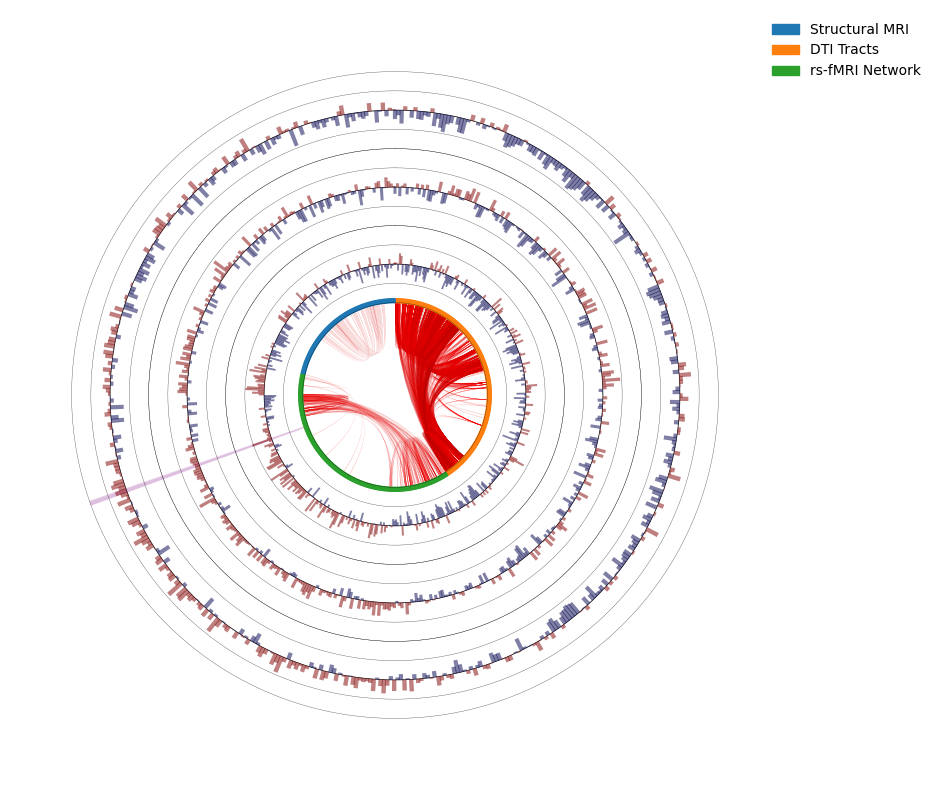

In [20]:
%%time
circosplot.plot(corr_df, gwas_group_dict, gwas_name, 
                sign_threshold=len(constants.METHODS)-1, # for the inner chordplot
                save=False)

The circle itself represents the gwas groups. 
The red lines inside are the mean correlations between the gwases inside these groups.
The brigher the red, the higher the correlation.

The three outer barplot circles represent the correlation between our gwas of interest and the gwases in the gwas groups per methods. 
From inside to outside the methods are H-MAGMA. LDSC, MAGMA (the order in the constants.py file). 
Red bars denote positive correlation and blue negative.

The big bars spanning the three outer circles denote whether the correlation is significant or not. 
If the big bar is purple, it is only significant in one method, green in two and red in all three methods.

## 5.     ES Gene Correlation <a id='5'></a>

We calculated the correlations between phenotypes, but we can also do this between cell-types.
This can be useful to double-check an enriched cell-type and see what other cell-types it is correlated with.
We give as input the datasets (specificity_id). 

In [21]:
datasets = df['specificity_id'].unique() # get all unique datasets
print(datasets)

['Allen_human_LGN' 'Allen_human_MTG' 'Descartes_Human_Cerebellum'
 'Descartes_Human_Cerebrum' 'DroNc_Human_Hippocampus'
 'GSE101601_Temporal_Cortex' 'GSE67835_Human_Cortex' 'PsychENCODE_DER-22'
 'mousebrain' 'tabula_muris']


We can calculate the ES gene correlation using:

In [22]:
%%time
es_corr_df = calculate_es_correlation.calculate_es_corr(datasets) # calculates correlation

CPU times: user 6min 31s, sys: 39.4 s, total: 7min 11s
Wall time: 5min 37s


In [23]:
display(es_corr_df)

,celltypex,celltypey,corr,pval,pval_bonferroni
0,"Allen_human_LGN, GABAergic.LGN_Inh_CTXN3","Allen_human_LGN, GABAergic.LGN_Inh_LAMP5",0.155456,3.503827e-15,5.194074e-10
1,"Allen_human_LGN, GABAergic.LGN_Inh_CTXN3","Allen_human_LGN, GABAergic.LGN_Inh_NTRK1",0.360667,1.160120e-115,1.719762e-110
2,"Allen_human_LGN, GABAergic.LGN_Inh_CTXN3","Allen_human_LGN, GABAergic.LGN_Inh_TRPC4",0.209286,6.473715e-26,9.596634e-21
3,"Allen_human_LGN, GABAergic.LGN_Inh_CTXN3","Allen_human_LGN, Glutamatergic.LGN_Exc_BTNL9",0.159302,1.347408e-09,1.997397e-04
4,"Allen_human_LGN, GABAergic.LGN_Inh_CTXN3","Allen_human_LGN, Glutamatergic.LGN_Exc_PRKCG_BCHE",0.246957,1.938275e-24,2.873299e-19
...,...,...,...,...,...
148235,"tabula_muris, Trachea.blood_cell","tabula_muris, Trachea.epithelial_cell",0.079243,1.409471e-02,1.000000e+00
148236,"tabula_muris, Trachea.blood_cell","tabula_muris, Trachea.mesenchymal_cell",0.111152,1.375545e-07,2.039108e-02
148237,"tabula_muris, Trachea.endothelial_cell","tabula_muris, Trachea.epithelial_cell",0.089872,9.832454e-04,1.000000e+00
148238,"tabula_muris, Trachea.endothelial_cell","tabula_muris, Trachea.mesenchymal_cell",0.149082,1.478933e-18,2.192370e-13


To only select for the correlations with our enriched cell-types we can first select these cell-types:

In [24]:
significant_celltypes = significant_counts.reset_index()[
    ['specificity_id','annotation']].drop_duplicates().values.tolist()
significant_celltypes = [f'{d}, {c}' for d,c in significant_celltypes]
display(significant_celltypes)

['mousebrain, MEINH10',
 'DroNc_Human_Hippocampus, GABA1',
 'mousebrain, MEGLU10',
 'mousebrain, MEGLU7',
 'mousebrain, MEGLU9',
 'Allen_human_LGN, GABAergic.LGN_Inh_LAMP5',
 'mousebrain, TEGLU10',
 'mousebrain, DEGLU4',
 'mousebrain, TEGLU16',
 'mousebrain, TEGLU17',
 'PsychENCODE_DER-22, Ex3e',
 'GSE67835_Human_Cortex, neurons',
 'DroNc_Human_Hippocampus, GABA2',
 'mousebrain, TEGLU4',
 'tabula_muris, Brain_Non-Myeloid.oligodendrocyte_precursor_cell',
 'Descartes_Human_Cerebrum, Cerebrum-Limbic_system_neurons',
 'Descartes_Human_Cerebrum, Cerebrum-Inhibitory_neurons',
 'tabula_muris, Brain_Non-Myeloid.neuron',
 'mousebrain, TEINH19',
 'mousebrain, TEINH14',
 'mousebrain, TEINH13',
 'mousebrain, TEGLU15',
 'tabula_muris, Pancreas.pancreatic_D_cell',
 'mousebrain, MEGLU8',
 'mousebrain, TEINH5',
 'mousebrain, MSN2',
 'mousebrain, MSN4',
 'mousebrain, TEGLU1',
 'mousebrain, TEGLU11',
 'mousebrain, TEINH15',
 'mousebrain, TEINH16',
 'mousebrain, TEINH12',
 'mousebrain, TEGLU18',
 'mouseb

Then we only show these correlations:

In [25]:
es_corr_df[
    (
        # get only celltypes significant in scz
        (es_corr_df['celltypex'].isin(significant_celltypes))
        |
        (es_corr_df['celltypey'].isin(significant_celltypes))
    )
    &
    # get only significant correlations
    (es_corr_df['pval_bonferroni']<=0.05)
].sort_values('corr', ascending=False)

,celltypex,celltypey,corr,pval,pval_bonferroni
118105,"mousebrain, MSN1","mousebrain, MSN2",0.659408,0.000000e+00,0.000000e+00
118594,"mousebrain, MSN3","mousebrain, MSN4",0.638636,0.000000e+00,0.000000e+00
138510,"mousebrain, TEINH11","mousebrain, TEINH12",0.570274,0.000000e+00,0.000000e+00
45872,"Descartes_Human_Cerebellum, Cerebellum-Purkinj...","Descartes_Human_Cerebrum, Cerebrum-SKOR2_NPSR1...",0.563110,0.000000e+00,0.000000e+00
134888,"mousebrain, TEGLU11","mousebrain, TEGLU3",0.557421,0.000000e+00,0.000000e+00
...,...,...,...,...,...
45873,"Descartes_Human_Cerebellum, Cerebellum-Purkinj...","Descartes_Human_Cerebrum, Cerebrum-Vascular_en...",-0.179869,2.042720e-17,3.028128e-12
45879,"Descartes_Human_Cerebellum, Cerebellum-Purkinj...","DroNc_Human_Hippocampus, MG",-0.180439,7.334857e-08,1.087319e-02
49009,"Descartes_Human_Cerebrum, Cerebrum-Limbic_syst...","Descartes_Human_Cerebrum, Cerebrum-Vascular_en...",-0.185862,1.014887e-50,1.504468e-45
45864,"Descartes_Human_Cerebellum, Cerebellum-Purkinj...","Descartes_Human_Cerebellum, Cerebellum-Vascula...",-0.198499,1.270287e-28,1.883073e-23
